In [1]:
from train import *

%load_ext autoreload
%autoreload 2

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dgl

# Dataset

TODO:
- [ ] include other augmentations

In [3]:
pgcl_dataset = module_dataset.PGCLDataset("REDDIT-BINARY")

In [4]:
type(pgcl_dataset[0])

tuple

In [5]:
np.random.seed(0)

pgcl_dataset[0]

(Graph(num_nodes=218, num_edges=480,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=218, num_edges=2,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=218, num_edges=34,
       ndata_schemes={}
       edata_schemes={}))

# DataLoader

In [6]:
config["data_loader"]

UsageError: Invalid config statement: '["data_loader"]', should be `Class.trait = value`.


In [7]:
pgcl_data_loader = pgcl_dataset.make_GraphDataLoader(
    {
        "batch_size":128,
        "num_workers":0,
    }
)

In [8]:
for i, b in enumerate(pgcl_data_loader):
    if i<2:
        print(i,b)
    else:
        break

0 [Graph(num_nodes=63371, num_edges=151784,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=63371, num_edges=586,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=63371, num_edges=15976,
      ndata_schemes={}
      edata_schemes={})]
1 [Graph(num_nodes=44122, num_edges=105272,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=44122, num_edges=578,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=44122, num_edges=13630,
      ndata_schemes={}
      edata_schemes={})]


In [9]:
b[0].edges()

(tensor([    0,     1,     2,  ..., 46528, 46528, 46528]),
 tensor([   36,    53,    53,  ..., 46500, 46509, 46510]))

In [10]:
b[0]

Graph(num_nodes=46529, num_edges=111430,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)})

# Model

In [11]:
nmb_prototypes=8
dataset_num_features=1

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = module_arch.PGCLModel(
    nmb_prototypes=nmb_prototypes,
    encoder_name = "pgcl",
    #encoder_args = {
    #    "input_dimension":128,
    #    "num_layers":2,
    #    "output_dimension":64,
    #    "hidden_dimension":64,
    #    "graph_pooling_type":'sum',
    #},
    encoder_args = {
        "num_features":1,
        "dim":64,
        "num_gc_layers":2,
    },
    dataset_num_features=dataset_num_features,
).to(device)

In [13]:
model

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (proj_head): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (proj_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=

# Trainer

In [14]:
CONFIG_PATH = "Configs/config_files/config_PGCL_default.json"#default_GCC_preMoCo.json"
#CONFIG_PATH = "Configs/config_files/config_graphmae_vGCN.json"#default_GCC_preMoCo_vGCN

config = ConfigParser.from_json(json_path = CONFIG_PATH)

In [15]:
# 2.2 get function handles of loss and metrics
criterion = torch.nn.CrossEntropyLoss()#config.init_obj('loss_type', module_loss)
metrics = None#[getattr(module_metric, met) for met in config['metrics']]

# 2.3 build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [16]:
trainer = module_train.PGCLTrainer(
    model,
    criterion,
    metrics,
    optimizer,
    config=config,
    device=device,
    data_loader=pgcl_data_loader,
    valid_data_loader=None,
    lr_scheduler=lr_scheduler,
    #**config['trainer_type']['args']
)

In [17]:
b[1]

Graph(num_nodes=46529, num_edges=600,
      ndata_schemes={}
      edata_schemes={})

In [18]:
emb, proto = model(b[1])

print(emb.shape, proto.shape)
emb

torch.Size([128, 128]) torch.Size([128, 8])


tensor([[ 0.0984,  0.1409, -0.0594,  ...,  0.1220, -0.0352,  0.0625],
        [ 0.0980,  0.1401, -0.0598,  ...,  0.1222, -0.0360,  0.0624],
        [ 0.0980,  0.1411, -0.0592,  ...,  0.1216, -0.0359,  0.0628],
        ...,
        [ 0.0979,  0.1410, -0.0594,  ...,  0.1214, -0.0361,  0.0629],
        [ 0.0980,  0.1410, -0.0594,  ...,  0.1214, -0.0360,  0.0628],
        [ 0.0984,  0.1409, -0.0594,  ...,  0.1219, -0.0352,  0.0625]],
       grad_fn=<CatBackward0>)

In [19]:
proto

tensor([[ 0.0338,  0.0119,  0.0290,  ..., -0.0308, -0.0431, -0.0884],
        [ 0.0338,  0.0117,  0.0288,  ..., -0.0312, -0.0427, -0.0890],
        [ 0.0337,  0.0115,  0.0291,  ..., -0.0309, -0.0433, -0.0884],
        ...,
        [ 0.0337,  0.0116,  0.0291,  ..., -0.0310, -0.0432, -0.0884],
        [ 0.0337,  0.0116,  0.0291,  ..., -0.0309, -0.0433, -0.0886],
        [ 0.0338,  0.0118,  0.0291,  ..., -0.0308, -0.0431, -0.0884]],
       grad_fn=<CatBackward0>)

In [20]:
trainer.queue.shape, trainer.queue

(torch.Size([2, 512, 128]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [21]:
trainer.crops_for_assign

[0, 1]

In [22]:
trainer.train()

Train Epoch: 1 [0/16 (0%)] Loss: 24.271507
Train Epoch: 1 [11/16 (69%)] Loss: 23.723022
    epoch          : 1
    loss           : 24.180291414260864
    time           : 00:00:30
    no improvement : 0
Saving current best: model_best.pth ...
Train Epoch: 2 [0/16 (0%)] Loss: 23.625372
Train Epoch: 2 [11/16 (69%)] Loss: 23.586422
    epoch          : 2
    loss           : 23.539547204971313
    time           : 00:00:30
    no improvement : 0
Saving current best: model_best.pth ...
Train Epoch: 3 [0/16 (0%)] Loss: 23.578051
Train Epoch: 3 [11/16 (69%)] Loss: 23.567650
    epoch          : 3
    loss           : 23.51083481311798
    time           : 00:00:29
    no improvement : 0
Saving current best: model_best.pth ...
Train Epoch: 4 [0/16 (0%)] Loss: 23.564569
Train Epoch: 4 [11/16 (69%)] Loss: 23.516636
    epoch          : 4
    loss           : 23.501896381378174
    time           : 00:00:29
    no improvement : 0
Saving current best: model_best.pth ...
Train Epoch: 5 [0/16 (0%)

In [23]:
#from Models.model_util import *
from Utils.tasks import *

In [24]:
%%time

test_classification = testmodel_dataset(
    model=trainer,
    dataset=None, # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0,
    n_repeat=10,
    dummy_baselines=["most_frequent","uniform"],
)

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (proj_head): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (proj_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=

In [158]:
model.embed(pgcl_dataset[0][0])

array([ -5.844165  ,   3.141825  ,  -2.572279  ,   0.02248323,
        -4.9117546 ,   1.119899  ,   7.485041  ,  10.695367  ,
        -1.3644395 ,   9.776119  ,   0.44265103,   5.822666  ,
        -3.6565971 ,  -5.2155285 ,  -1.9216762 ,  -4.135167  ,
        -1.7205423 ,  -3.525338  ,  -3.6488445 ,  -0.5109011 ,
        -3.336716  ,  -7.4815874 ,   4.640832  ,  10.690537  ,
        -3.203807  ,   1.9211925 ,  -7.997982  ,  -2.830963  ,
        -7.4796314 ,  -0.71003747,   1.7807088 ,  -3.444867  ,
        -2.3676527 ,  -1.0992916 ,  -5.015535  ,   0.64291835,
         7.2229896 ,  -6.626932  ,  -4.6056647 ,  -0.10797268,
        -5.453995  ,  -2.1088543 , -14.903328  ,   0.22312748,
         7.9879227 ,   2.9650183 ,  -7.0413237 ,   8.941975  ,
         4.899534  ,   0.9074498 ,   5.132999  ,   0.9263282 ,
        -9.751461  ,  10.85007   ,  -4.235475  ,   1.9502381 ,
         1.4417906 ,  -0.69354033,  -5.7020025 ,  -0.18768215,
        -9.909359  ,  -4.676936  ,   5.9162316 ,  -3.38

In [98]:
model

PGCLModel(
  (encoder): GIN(
    (layers): ModuleList(
      (0): GINLayer(
        (activation): Identity()
        (mlp): MLP(
          (layers): ModuleList(
            (0): PLayer(
              in_features=128, out_features=64, bias=True
              (act): Identity()
              (norm): Identity()
            )
            (1): PLayer(
              in_features=64, out_features=64, bias=True
              (act): Identity()
              (norm): Identity()
            )
          )
        )
        (apply_func): ApplyNodeFunc(
          (mlp): MLP(
            (layers): ModuleList(
              (0): PLayer(
                in_features=128, out_features=64, bias=True
                (act): Identity()
                (norm): Identity()
              )
              (1): PLayer(
                in_features=64, out_features=64, bias=True
                (act): Identity()
                (norm): Identity()
              )
            )
          )
          (norm): Identity()
   

In [77]:
dgl.unbatch(b[0])

[Graph(num_nodes=88, num_edges=192,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=380, num_edges=900,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=294, num_edges=696,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=577, num_edges=1492,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=357, num_edges=900,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=69, num_edges=152,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'count': Sc

# 🌡 Best `trad_degs` ?

- Output dimension : 64, meaning `bins:64`
- Max degrees in `np.linspace(32, 1024, 16)`

In [7]:
import json
import numpy as np
from tqdm import tqdm
import Utils.tasks as tasks

from Models.model_grssl import *
from DataLoader.data_loader import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
OUTPUT_DIM = 64

min_tested_deg = 32
max_tested_deg = 1024
step_size = 32

test_degs = np.linspace(32, 1024, int((max_tested_deg-min_tested_deg)/step_size)+1)

In [9]:
test_trad_degs = TradModel(stats_dict = {
    "deg": {
        "bins":64,
        "range":[0,10]
    }
}
         )

In [10]:
dataset = GraphDataset(
    dgl_graphs = "../data/data_gnns/graphs_catalogue.csv"
    , og_format="graph-tool"
    , from_csv = True
)

100%|████████████| 4489/4489 [13:11<00:00,  5.67it/s, graph=yeast_transcription]


In [14]:
accuracies = []
stds = []

for md in tqdm(test_degs):
    test_trad_degs_md = TradModel(
        stats_dict = {
            "deg": {
                "bins":64,
                "range":[0,md]
            }
        }
    )
    
    embeddings = [test_trad_degs_md.embed(g) for g in dataset.graphs]
    
    res_dict = tasks.svc_classify(
        x = np.array(embeddings),
        y = np.array(dataset.graphs_labels),
        search=False,
    )
    
    accuracies += [res_dict["Micro-F1"]]
    stds += [res_dict["Micro-F1 (std.)"]]
    

100%|███████████████████████████████████████████| 32/32 [16:32<00:00, 31.00s/it]


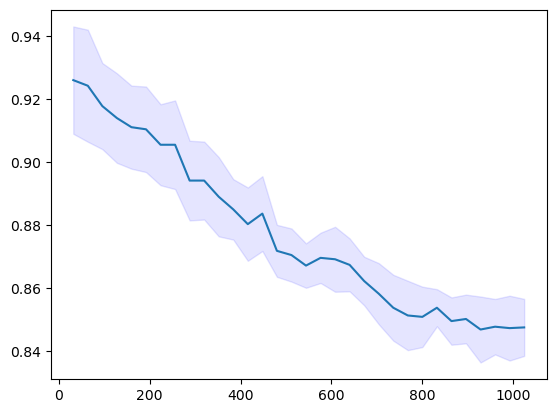

In [17]:
from matplotlib import pyplot as plt

accuracies = np.array(accuracies)
stds = np.array(stds)

#some example data
#accuracies = (1+np.random.random(len(test_degs))) * test_degs
#some confidence interval
#stds = np.std(accuracies)*(1+np.random.random(len(test_degs)))

fig, ax = plt.subplots()
ax.plot(test_degs[:len(accuracies)], accuracies)
ax.fill_between(
    test_degs[:len(accuracies)]
    , (accuracies-stds), (accuracies+stds)
    , color='b'
    , alpha=.1 
)

In [2]:
OUTPUT_DIM = 64

min_tested_deg = 32
max_tested_deg = 1024
step_size = 16

test_degs = np.linspace(32, 1024, int((max_tested_deg-min_tested_deg)/step_size)+1)

In [3]:
DATASET_CLASSIFICATION = "../data/data_gnns/graphs_catalogue.csv"
#PATH_TO_MODEL_TRADDEGS = "./saved/best_models/trad_degs/"

PATH_TO_TRADDEGS_CONFIG = "./Configs/config_files/def_trad.json"

In [ ]:
accuracies = []
stds = []

for md in test_degs:
    # open json and change parameters
    with open(PATH_TO_TRADDEGS_CONFIG) as json_config:
        config_trad = json.load(json_config)
    json_config.close()
    
    config_trad["arch"]["args"]["stats_dict"]["deg"]["bins"] = OUTPUT_DIM
    config_trad["arch"]["args"]["stats_dict"]["deg"]["range"] = [0, md]
    
    with open(PATH_TO_TRADDEGS_CONFIG, "w") as json_config:
        json.dump(config_trad, json_config)
    json_config.close()
    
    # run experiment
    test_classification_md = tasks.testmodel_dataset(
        model=PATH_TO_TRADDEGS_CONFIG,
        dataset=DATASET_CLASSIFICATION#"REDDIT-BINARY"
    )
    
    # store scores
    accuracies += [test_classification_md.scores["Micro-F1"]]
    stds += [test_classification_md.scores['Micro-F1 (std.)']]

100%|████████████| 4489/4489 [17:49<00:00,  4.20it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 32.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                 

100%|███████████| 4489/4489 [00:08<00:00, 520.04it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 48.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                 

100%|███████████| 4489/4489 [00:07<00:00, 565.66it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 64.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                 

100%|███████████| 4489/4489 [00:08<00:00, 553.93it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 80.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                 

100%|███████████| 4489/4489 [00:08<00:00, 525.46it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 96.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                 

100%|███████████| 4489/4489 [00:08<00:00, 547.39it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 112.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:08<00:00, 558.33it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 128.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:07<00:00, 585.69it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 144.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:08<00:00, 508.40it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 160.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:08<00:00, 548.65it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 176.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:07<00:00, 588.19it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 192.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

 95%|█████▋| 4285/4489 [00:07<00:00, 1107.34it/s, graph=us_agencies/mississippi]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TradModel(
	 — deg      ( bins : 64   | range: [0, 208.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:07<00:00, 587.86it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 224.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:07<00:00, 581.43it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 240.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:09<00:00, 498.75it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 256.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

 98%|███████▊| 4384/4489 [00:07<00:00, 1165.13it/s, graph=us_agencies/minnesota]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TradModel(
	 — deg      ( bins : 64   | range: [0, 272.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:09<00:00, 489.51it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 288.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

100%|███████████| 4489/4489 [00:07<00:00, 599.18it/s, graph=yeast_transcription]


TradModel(
	 — deg      ( bins : 64   | range: [0, 304.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

 97%|████▊| 4337/4489 [00:07<00:00, 1198.26it/s, graph=us_agencies/pennsylvania]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TradModel(
	 — deg      ( bins : 64   | range: [0, 320.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

 95%|███████▋| 4280/4489 [00:07<00:00, 1221.38it/s, graph=us_agencies/louisiana]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TradModel(
	 — deg      ( bins : 64   | range: [0, 336.0])
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — mean                           |   2421.131531933899|
|nodes — median                         |               747.5|
|nodes — min                            |                   7|
|nodes — max                            |               69082|
|edges — tot                            |            52679396|
|edges — mean                           |   11764.04555605181|
|edges — median                         |              4155.0|
|edges — min                            |                  28|
|edges — max                            |              198694|
|number of labels                       |                

In [ ]:
from matplotlib import pyplot as plt

accuracies = np.array(accuracies)
stds = np.array(stds)

#some example data
#accuracies = (1+np.random.random(len(test_degs))) * test_degs
#some confidence interval
#stds = np.std(accuracies)*(1+np.random.random(len(test_degs)))

fig, ax = plt.subplots()
ax.plot(test_degs[:len(accuracies)], accuracies)
ax.fill_between(test_degs[:len(accuracies)]
                , (accuracies-stds), (accuracies+stds)
                , color='b'
                , alpha=.1 
               )